In [42]:
# Importing Tensorflow into colab
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

TF version: 2.4.1
TF Hub version: 0.11.0


In [43]:
# GPU check
print("GPU is AVAILABLE" if tf.config.list_physical_devices("GPU") else "GPU is NOT AVAILABLE")

GPU is AVAILABLE


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Getting our data ready (turning into Tensors)
labels_csv = pd.read_csv("drive/MyDrive/Dog-Breed-Identification/labels.csv")

labels = labels_csv["breed"]
labels = np.array(labels)

# Finding unique label values
unique_breeds = np.unique(labels)

In [45]:
# Defining image size
IMG_SIZE = 224

# function
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.

  1. Takes an image file-path as input.
  2. Using TensorFlow to read the file and save it to a variable, `image`.
  3. Turning our `image` (a jpg) into Tensors.
  4. Normalize our `image` (convert colour channel values from 0-255 to 0-1). 
  5. Resize the `image` to be a shape of (224, 224).
  6. Return the modified `image`. 
  """

  # Reading image file
  image = tf.io.read_file(image_path)
  # Turning the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Converting the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resizing the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

In [46]:
# Defining the batch size, 32
BATCH_SIZE = 32

# function : to turn data into batches
def create_data_batches(X, Y=None, batch_size=BATCH_SIZE  , valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (Y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only file paths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it 
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # file-paths
                                               tf.constant(Y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch
  
  else:
    print("Creating training data batches...")
    # Turning file-paths and labels into Tensors 
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(Y)))
    # Shuffling path-names and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches 
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [47]:
# Turn prediction probabilities into their respective label (easier to understand)
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]



In [48]:
# Create a function to load a trained model 
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [49]:
# Load in the full model
loaded_full_model = load_model("drive/My Drive/Dog-Breed-Identification/models/20210317-11131615979613-full-image-set-mobilenetv2-Adam.h5")

Loading saved model from: drive/My Drive/Dog-Breed-Identification/models/20210317-11131615979613-full-image-set-mobilenetv2-Adam.h5


## Making predictions on custom images

To make predictions on custom images we will:
* Get the filepaths of our own images.
* Turn the filepaths into data batches using `create_data_batches()`. And since our custom images won't have labels, we set the `test_data` parameter to `True`.
* Pass the custom image data batch to our model's `predict()` method.
* Convert the prediction output probabilities to predictions labels.
* Compare the prediction labels to the custom images.

In [50]:
  # Getting custom image file-paths
import os

custom_path = "drive/My Drive/Dog-Breed-Identification/my-dog-photos/"
custom_image_paths = [custom_path + fname for fname in os.listdir(custom_path)]

In [51]:
custom_image_paths

['drive/My Drive/Dog-Breed-Identification/my-dog-photos/German_Shepherd.jpg',
 'drive/My Drive/Dog-Breed-Identification/my-dog-photos/labrador-retriever.jpg',
 'drive/My Drive/Dog-Breed-Identification/my-dog-photos/Doberman.jpg',
 'drive/My Drive/Dog-Breed-Identification/my-dog-photos/Labradoodle_Brown.jpg']

In [52]:
# Turn custom images into batch datasets
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data 

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [53]:
# Making predictions on the custom data 
custom_preds = loaded_full_model.predict(custom_data)

In [54]:
# Getting custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['german_shepherd', 'labrador_retriever', 'doberman', 'giant_schnauzer']

In [55]:
custom_images = []
 
# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

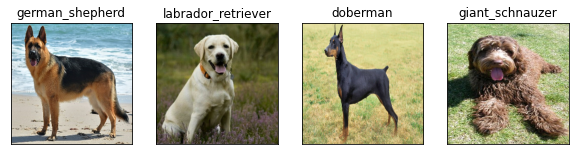

In [56]:
# Check custom image predictions
plt.figure(figsize=(10,10))
for i, image in enumerate(custom_images):
  plt.subplot(1, len(custom_preds), i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)